In [73]:
import pathlib as pl
from collections import defaultdict
from configparser import ConfigParser
import itertools as itt

import joblib as jl
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import pearsonr, linregress, sem, wilcoxon, norm
from sklearn.metrics import r2_score
from nems.db import batch_comp

from src.data.load import get_batch_ids
from src.root_path import config_path, root_path
from src.utils.subsets import cellid_A1_fit_set, cellid_PEG_fit_set, batch_map, all_cells, good_sites
from src.utils.tools import decimate_xy
from src.visualization.palette import *
from src.visualization.interactive import plot_raw_pair
from src.models.modelnames import modelnames as all_modelnames

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))


In [2]:
folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220520_minimal_DF'
model_df_file = pl.Path(config['paths']['analysis_cache']) / f'220412_resp_pred_metrics_by_chunks'
working_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220531_fig6_wdf'

recache_wdf = True

if working_DF_file.exists() and not recache_wdf:
    resp_wide = jl.load(working_DF_file)
    print("found and loaded working data fram from cache")
else:
    print('creating working dataframe ...')

    filter = jl.load(summary_DF_file).query(
        f"mult_comp_corr == 'bf_cp' and source == 'real' and cluster_threshold == 0.05 and "
        f"metric == 'integral' and analysis == 'SC'"
        f"and value > 0 "
        ).loc[:,
             ['id', 'context_pair', 'probe']]  # these are the minimum columns to define an individual instance

    DF = jl.load(model_df_file)

    resp_wide = pd.merge(
        filter, DF, on=['id', 'context_pair', 'probe'], validate='1:m'
    ).query("metric in ['integral', 'mass_center']").rename(columns={'resp': 'response'})

    # del (DF, filter)
    jl.dump(resp_wide, working_DF_file)
    print('done')

print(resp_wide.shape)
resp_wide.head(10)

creating working dataframe ...
done
(647320, 12)


,id,context_pair,probe,value,metric,response,modelname,nickname,site,region,stim_count,time_bin
0,TNC009a-27-1,00_01,1,6.185685,integral,36.000000,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC009a,A1,10,A
1,TNC009a-27-1,00_01,1,140.000397,mass_center,156.111115,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC009a,A1,10,A
4,TNC009a-27-1,00_01,1,2.255303,integral,28.000000,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC009a,A1,10,B
5,TNC009a-27-1,00_01,1,313.358704,mass_center,317.857147,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC009a,A1,10,B
8,TNC009a-27-1,00_01,1,1.040909,integral,13.000000,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC009a,A1,10,C
9,TNC009a-27-1,00_01,1,625.083557,mass_center,656.153870,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC009a,A1,10,C
12,TNC009a-27-1,00_01,1,1.996165,integral,17.000000,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC009a,A1,10,D
13,TNC009a-27-1,00_01,1,837.177673,mass_center,865.882324,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC009a,A1,10,D
16,TNC009a-27-1,00_01,1,11.478063,integral,94.000000,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC009a,A1,10,full
17,TNC009a-27-1,00_01,1,339.300934,mass_center,401.808502,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC009a,A1,10,full


In [3]:
working_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220531_fig6_wdf'
jl.dump(resp_wide, working_DF_file)


['/auto/users/mateo/code/context_probe_analysis/data/220531_fig4_wdf']

# Full scatter example panels
in this case for the worst and best model in the two time bins where they diverge

In [4]:
# save all the panels in a convenient dictionary.
panels = defaultdict(list)

In [26]:
# panels = defaultdict(list)
decimate = 1000
time_bins = ['A', 'B', 'C']
selected = ['matchl_STRF', 'matchl_full']

for cc, tbin in enumerate(time_bins):
    panelname = f'{tbin}_scatter'
    if panelname in panels:
        panels.pop(panelname)

    ranges = list()
    for nn, nknm in enumerate(selected):
        subplotdf = resp_wide.query(f"metric == 'integral' and time_bin == '{tbin}' and  nickname == '{nknm}'")

        x = subplotdf.response.values.astype(float)
        y = subplotdf.value.values.astype(float)
        R2 = r2_score(x, y)
        slope, bias, r, pval, _ = linregress(x, y)
        print(f"{tbin}, {nknm}, R2={R2}, r={r}, pvalue={pval}")

        xm, ym = decimate_xy(x, y, decimate, by_quantiles=False)

        panels[panelname].append(
            go.Scatter(x=xm, y=ym, mode='markers',
                       opacity=0.8,
                       marker=dict(
                           opacity=0.8,
                           color=MODEL_COLORMAP[nknm],
                           size=2
                       ),
                       name=f'{nknm}',
                       hoverinfo='skip', showlegend=False
                       )
        )

        model_range = [np.nanmin(np.stack([xm, ym])),
                       np.nanmax(np.stack([xm, ym]))]

        # regression lines
        panels[panelname].append(
            go.Scatter(x=model_range,
                       y=np.asarray(model_range) * slope + bias,
                       mode='lines',
                       line=dict(
                           color=MODEL_COLORMAP[nknm],
                           width=1
                       ),
                       opacity=1,
                       name=f'{nknm}',
                       hoverinfo='skip',
                       showlegend=False
                       )
        )

        ranges.append(model_range)

    # unity line
    ranges = np.stack(ranges, axis=1)
    plot_range = [ranges[0, :].min(), ranges[1, :].max()]
    plot_range = [plot_range[0] - (np.diff(plot_range)[0] * 0.025),
                  plot_range[1] + (np.diff(plot_range)[0] * 0.025)]

    panels[panelname].append(go.Scatter(x=plot_range, y=plot_range, mode='lines',
                                        line=dict(color='black',
                                                  dash='dot',
                                                  width=1),
                                        showlegend=False)
                             )

    # interval anotationse
    prange = plot_range[1] - plot_range[0]
    x = plot_range[0] + prange * 0.25
    y = plot_range[0] + prange * 0.75
    panels[panelname].append(go.Scatter(x=[x], y=[100],
                                        text=[tbin],
                                        mode='text',
                                        textposition='bottom center',
                                        textfont_size=10,
                                        showlegend=False)
                             )

A, matchl_STRF, R2=-0.5983234872414029, r=0.4921373901082613, pvalue=0.0
A, matchl_full, R2=-0.07640586516500036, r=0.6250678286860144, pvalue=0.0
B, matchl_STRF, R2=-0.6288761391279125, r=0.40506701598283235, pvalue=0.0
B, matchl_full, R2=0.08917797219695689, r=0.6607060702789449, pvalue=0.0
C, matchl_STRF, R2=-0.5672051745526001, r=0.37490099029137425, pvalue=0.0
C, matchl_full, R2=-0.17414740281172425, r=0.6251585441580597, pvalue=0.0


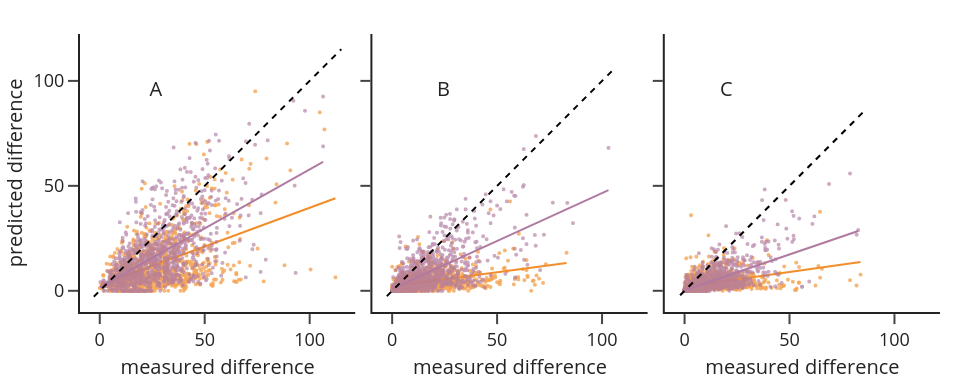

In [27]:
# test plotting please ignore
fig = make_subplots(rows=1, cols=len(time_bins), shared_yaxes='all', shared_xaxes='all',
                    horizontal_spacing=0.02, vertical_spacing=0.01)
for tt, tbin in enumerate(time_bins):
    panel = panels[f'{tbin}_scatter']
    fig.add_traces(panel, rows=[1] * len(panel), cols=[tt + 1] * len(panel))

w, h = 5, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10))

fig.update_xaxes(autorange=True, constrain='domain',
                 title=dict(text='measured difference', font_size=10, standoff=0),
                 tickfont_size=9)
fig.update_yaxes(scaleanchor='x', constrain='domain',
                 tickfont_size=9)
fig.update_yaxes(title=dict(text='predicted difference', font_size=10, standoff=0), col=1, row=1)

filename = folder / 'fig6_pred_resp_diff_regression'
fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)

# bars summarizing the rest of models and time bins

In [115]:
# calculates pearsons correlation between real and predicted integral values, for all combinations of models
# and time bin chunks
panelname = 'metric_reg_bars'

def pearsonsr_bootstraped(x, y, montecarlo=1000, keep_vals=False):
    r_val, p_val = pearsonr(x, y)
    pearsons = np.empty(montecarlo)
    if montecarlo > 2:
        for ii in range(montecarlo):
            idxs = np.random.choice(np.arange(x.size), size=x.size, replace=True)
            r, _ = pearsonr(x[idxs], y[idxs])
            pearsons[ii] = r

        e = np.std(pearsons)
    else:
        e = 0

    if keep_vals == False:
        return r_val, p_val, e
    else:
        return pearsons


def jknf(x, y, njacks= 20):
    pred = x
    resp = y
    chunksize = int(np.ceil(len(pred) / njacks / 10))
    chunkcount = int(np.ceil(len(pred) / chunksize / njacks))
    idx = np.zeros((chunkcount, njacks, chunksize))
    for jj in range(njacks):
        idx[:, jj, :] = jj
    idx = np.reshape(idx, [-1])[:len(pred)]
    jc = np.zeros(njacks)
    for jj in range(njacks):
        ff = (idx != jj)
        jc[jj] = np.corrcoef(pred[ff], resp[ff])[0, 1]

    r_val = np.nanmean(jc)
    e = np.nanstd(jc) * np.sqrt(njacks-1)
    var = np.nanmean((jc-r_val)**2) * (njacks-1)

    return r_val, var, e

to_regress = resp_wide.query(f"metric == 'integral'").loc[:, ['time_bin', 'nickname', 'response', 'value']]

# reg_df = to_regress.groupby(['time_bin', 'nickname'], observed=True).apply(
#     lambda x: pearsonsr_bootstraped(
#         x['response'].values, x['value'].values, 1000)).reset_index()

reg_df = to_regress.groupby(['time_bin', 'nickname'], observed=True).apply(
    lambda x: jknf(
        x['response'].values, x['value'].values, 20))

reg_df = pd.DataFrame(reg_df.tolist(), index=reg_df.index, columns=['pearsonsr', 'var', 'std'])

# this is time consuming, that is why i have separated data generation from plotting

In [116]:
pair_stats = list()
# performs pairwise comparisons
for tb in ['A', 'B', 'C', 'D']:
    for nck1, nck2 in itt.combinations(reg_df.index.unique(level='nickname'),r=2):
        Q = (reg_df.loc[(tb, nck1), 'pearsonsr'] - reg_df.loc[(tb, nck2), 'pearsonsr']) / \
            np.sqrt(reg_df.loc[(tb, nck1), 'var'] + reg_df.loc[(tb, nck2), 'var'])
        pval = norm(0,1).pdf(Q)

        d = dict(time_bin=tb, A=nck1, B=nck2, stat=Q, pvalue=pval)
        pair_stats.append(d)
        # print(f'{tb} {nck1} vs {nck2}: stat={Q:.3f}, pvalue={pval}')

pair_stats = pd.DataFrame(pair_stats).set_index(['time_bin', 'A', 'B'])

pair_stats['corr_pval'] = pair_stats['pvalue'] * 6
pair_stats['0.05'] = pair_stats['corr_pval'] < 0.05
pair_stats['0.01'] = pair_stats['corr_pval'] < 0.01
pair_stats['0.001'] = pair_stats['corr_pval'] < 0.001
pair_stats

stat        pvalue     corr_pval  \
time_bin A           B                                                    
A        matchl_STRF matchl_self  -2.507775  1.719037e-02  1.031422e-01   
                     matchl_pop   -6.136314  2.656879e-09  1.594127e-08   
                     matchl_full  -7.319498  9.273293e-13  5.563976e-12   
         matchl_self matchl_pop   -3.812387  2.785018e-04  1.671011e-03   
                     matchl_full  -4.883289  2.646704e-06  1.588022e-05   
         matchl_pop  matchl_full  -0.798137  2.901231e-01  1.740739e+00   
B        matchl_STRF matchl_self  -7.120751  3.894381e-12  2.336629e-11   
                     matchl_pop   -8.761511  8.546826e-18  5.128096e-17   
                     matchl_full -12.635266  8.577629e-36  5.146577e-35   
         matchl_self matchl_pop   -1.399281  1.498782e-01  8.992691e-01   
                     matchl_full  -4.655431  7.846373e-06  4.707824e-05   
         matchl_pop  matchl_full  -3.268138  1.912579e-03  1.147548e-02   
C        matchl_STRF matchl_self  -9.917381  1.751923e-22  1.051154e-21   
                     matchl_pop   -7.126543  3.736961e-12  2.242176e-11   
                     matchl_full -11.314967  6.307810e-29  3.784686e-28   
         matchl_self matchl_pop    3.613094  5.836764e-04  3.502058e-03   
                     matchl_full  -1.697315  9.447902e-02  5.668741e-01   
         matchl_pop  matchl_full  -5.449391  1.420810e-07  8.524863e-07   
D        matchl_STRF matchl_self  -8.718215  1.247787e-17  7.486719e-17   
                     matchl_pop   -6.584380  1.537080e-10  9.222479e-10   
                     matchl_full  -9.981630  9.244654e-23  5.546792e-22   
         matchl_self matchl_pop    2.363641  2.442037e-02  1.465222e-01   
                     matchl_full  -1.160659  2.034158e-01  1.220495e+00   
         matchl_pop  matchl_full  -3.603851  6.034735e-04  3.620841e-03   

                                   0.05   0.01  0.001  
time_bin A           B                                 
A        matchl_STRF matchl_self  False  False  False  
                     matchl_pop    True   True   True  
                     matchl_full   True   True   True  
         matchl_self matchl_pop    True   True  False  
                     matchl_full   True   True   True  
         matchl_pop  matchl_full  False  False  False  
B        matchl_STRF matchl_self   True   True   True  
                     matchl_pop    True   True   True  
                     matchl_full   True   True   True  
         matchl_self matchl_pop   False  False  False  
                     matchl_full   True   True   True  
         matchl_pop  matchl_full   True  False  False  
C        matchl_STRF matchl_self   True   True   True  
                     matchl_pop    True   True   True  
                     matchl_full   True   True   True  
         matchl_self matchl_pop    True   True  False  
                     matchl_full  False  False  False  
         matchl_pop  matchl_full   True   True   True  
D        matchl_STRF matchl_self   True   True   True  
                     matchl_pop    True   True   True  
                     matchl_full   True   True   True  
         matchl_self matchl_pop   False  False  False  
                     matchl_full  False  False  False  
         matchl_pop  matchl_full   True   True  False

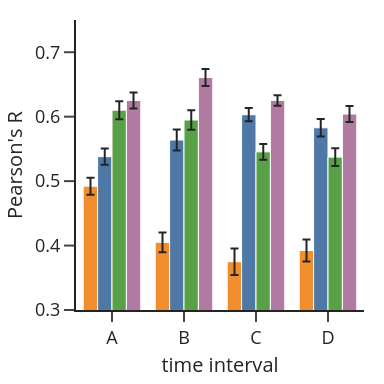

In [117]:
panelname = 'metric_reg_bars'
DISPLAY_NAME_MAP = {'matchl_STRF': 'STRF',
                    'matchl_self': 'Self',
                    'matchl_pop': 'Pop',
                    'matchl_full': 'Full',
                    }
# toplot = pd.merge(reg_df, det_df, on=['time_bin', 'nickname'], validate='1:1')
toplot = reg_df.reset_index().query(f"time_bin != 'full'")
toplot['display_name'] = toplot.nickname.apply(lambda x: DISPLAY_NAME_MAP[x])
DP_COLORMAP = {DISPLAY_NAME_MAP[nknm]: MODEL_COLORMAP[nknm] for nknm in DISPLAY_NAME_MAP.keys()}

# creates and stores panel
bars = px.bar(data_frame=toplot, x='time_bin', y='pearsonsr', color='display_name',
              error_y='std', error_y_minus=None,
              barmode='group',
              # custom_data=['pvalue'], text='display_name',
              category_orders={'time_bin': ['full', 'A', 'B', 'C', 'D'],
                               'display_name': ['STRF',
                                                'Self',
                                                'Pop',
                                                'Full']},
              # color_discrete_map=MODEL_COLORMAP,
              color_discrete_map=DP_COLORMAP,
              )

bars.update_traces(error_y=dict(thickness=1,
                                width=2),
                   )

# test plotting please ignore
if panelname in panels:
    panels.pop(panelname)
panels[panelname].extend(bars['data'])

panel = panels[panelname]
fig = go.Figure().add_traces(panel)

w, h = 2, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10),
                  showlegend=False,
                  legend=dict(
                      orientation="h",
                      yanchor="bottom",y=1,
                      xanchor="left",x=0,
                      font_size=9
                  ))
fig.update_xaxes(title=dict(text="time interval", font_size=10, standoff=0),
                 tickfont_size=9)
fig.update_yaxes(range=[0.3,0.75],title=dict(text="Pearson's R", font_size=10, standoff=0),
                 tickfont_size=9)

filename = folder / 'fig6_all_diff_regression_bars'
fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)

### mean and SEM for all bars?

In [10]:
print(toplot)

   time_bin     nickname  pearsonsr  pvalue       std display_name
0         A  matchl_STRF   0.494482     0.0  0.008348         STRF
1         A  matchl_self   0.548067     0.0  0.007439         Self
2         A   matchl_pop   0.602663     0.0  0.007031          Pop
3         A  matchl_full   0.639958     0.0  0.006206         Full
4         B  matchl_STRF   0.394048     0.0  0.007772         STRF
5         B  matchl_self   0.566119     0.0  0.006755         Self
6         B   matchl_pop   0.598656     0.0  0.007523          Pop
7         B  matchl_full   0.658673     0.0  0.006425         Full
8         C  matchl_STRF   0.375325     0.0  0.009412         STRF
9         C  matchl_self   0.593830     0.0  0.007472         Self
10        C   matchl_pop   0.555179     0.0  0.008147          Pop
11        C  matchl_full   0.620695     0.0  0.007272         Full
12        D  matchl_STRF   0.395789     0.0  0.008232         STRF
13        D  matchl_self   0.592561     0.0  0.007423         

### quantifications

In [11]:
to_regress = resp_wide.query(f"metric == 'integral'").loc[:, ['id', 'time_bin', 'nickname', 'response', 'value']]
print(to_regress.groupby(['time_bin', 'nickname'], observed=True).agg(count=('response', 'count')))
regr_neu = set(to_regress['id'].unique())
print(len(regr_neu))

                      count
time_bin nickname          
A        matchl_STRF  16183
         matchl_self  16183
         matchl_pop   16183
         matchl_full  16183
B        matchl_STRF  16183
         matchl_self  16183
         matchl_pop   16183
         matchl_full  16183
C        matchl_STRF  16183
         matchl_self  16183
         matchl_pop   16183
         matchl_full  16183
D        matchl_STRF  16183
         matchl_self  16183
         matchl_pop   16183
         matchl_full  16183
full     matchl_STRF  16183
         matchl_self  16183
         matchl_pop   16183
         matchl_full  16183
243


# General model fitness
this is a usefull plot that should be refactored into interactive

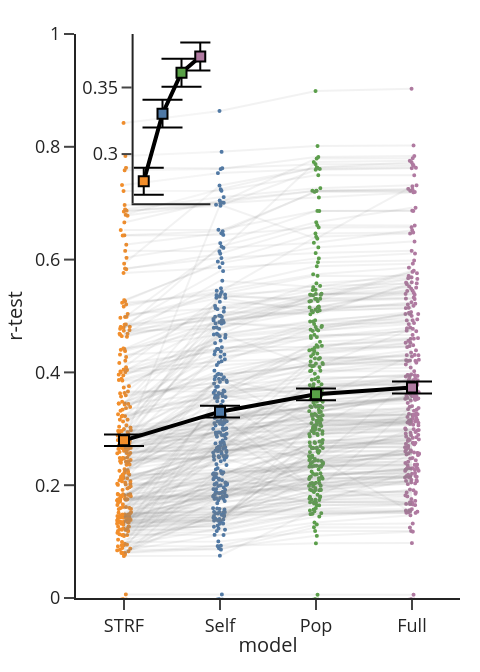

In [12]:
# panels = defaultdict(list)
stat = 'r_test'
cellids = cellid_A1_fit_set.union(cellid_PEG_fit_set)
nicknames = ['matchl_STRF', 'matchl_self', 'matchl_pop', 'matchl_full']
modelnames = [mod for key, mod in all_modelnames.items() if key in nicknames]

DF = batch_comp(batch=[326, 327], modelnames=modelnames, cellids=cellids, stat=stat)
DFfloor = batch_comp(batch=[326, 327], modelnames=modelnames, cellids=cellids, stat='r_floor')

# nan out prediciton values smaller than r-floor, arr is a view of the DF data, the replacement is in place
arr = DF.values
arr[DF.values <= DFfloor.values] = np.nan

display_names = [DISPLAY_NAME_MAP[nknm] for nknm in nicknames]
DF.columns = display_names
DFfloor.columns = display_names
DF.reset_index(inplace=True)
DFfloor.reset_index(inplace=True)

# add region information, is this really needed??
A1df = get_batch_ids(326)
A1df['region'] = 'A1'
PEGdf = get_batch_ids(327)
PEGdf['region'] = 'PEG'
regdf = pd.concat([A1df, PEGdf])

wide = pd.merge(DF.dropna(), regdf, on='cellid').rename(columns={'cellid': 'id', 'siteid': 'site'})
toplot = pd.melt(wide, id_vars=['id', 'site', 'region'], value_vars=display_names, var_name='model', value_name=stat)

# creates and stores panels
# single lines grayed out
single_lines = list()
for ll in wide.loc[:, display_names].values:
    single_lines.append(
        go.Scatter(x=display_names, y=ll,
                   mode='lines',
                   opacity=0.1,
                   line=dict(
                       color='gray',
                       width=1
                   ),
                   showlegend=False
                   )
    )

# mean and SEM line+markers
mean = wide.loc[:, display_names].values.mean(axis=0)
err = sem(wide.loc[:, display_names].values, axis=0)

# added line to this single call, make sure it actually works
mean_markers = go.Scatter(x=display_names, y=mean,
                          mode='markers+lines',
                          opacity=1,
                          showlegend=False,
                          marker=dict(color=[MODEL_COLORMAP[nknm] for nknm in nicknames],
                                      symbol='square',
                                      size=5,
                                      line=dict(color='black',
                                                width=1)
                                      ),
                          error_y=dict(array=err,
                                       color='black',
                                       thickness=1,
                                       width=10
                                       ),
                          line=dict(color='black'
                                    )
                          )

# individual dots
strip = px.strip(toplot, y=stat, x='model', color='model',
                 color_discrete_map={DISPLAY_NAME_MAP[nknm]: clr for nknm, clr in
                                     MODEL_COLORMAP.items()},

                 )
strip = strip.update_traces(marker=dict(opacity=1,
                                        size=2)
                            )['data']

if 'model_fitness' in panels:
    panels.pop('model_fitness')
if 'model_fitness_summary' in panels:
    panels.pop('model_fitness_summary')

panels['model_fitness'].extend(single_lines)
panels['model_fitness'].extend(strip)
panels['model_fitness'].append(mean_markers)

panels['model_fitness_summary'].append(mean_markers)

# test plotting please ignore
panel1 = panels['model_fitness']
panel2 = panels['model_fitness_summary']
fig = make_subplots(cols=1, rows=2, shared_xaxes=False)
fig.add_traces(panel1, cols=[1] * len(panel1), rows=[1] * len(panel1))
fig.add_traces(panel2, cols=[1] * len(panel2), rows=[2] * len(panel2))

w, h = 2.5, 3.5# in inches
_ = fig.update_layout(template='simple_white',
                      margin=dict(l=10, r=10, t=10, b=10),
                      width=round(96 * w), height=round(96 * h),
                      xaxis1=dict(domain=[0, 1], anchor='y1',
                                  title_text='model'),
                      yaxis1=dict(domain=[0, 1], anchor='x1',
                                  range=[0, 1],
                                  title_text='r-test'),
                      xaxis2=dict(domain=[0.15, 0.35], anchor='y2',
                                  ticks='', showticklabels=False),
                      yaxis2=dict(domain=[0.7, 1], anchor='x2'),
                      showlegend=False,
                      plot_bgcolor='rgba(256,256,256,0.2)')  # background color changes for all subplots,

fig.update_xaxes(title=dict(font_size=10, standoff=0), tickfont_size=9)
fig.update_yaxes(title=dict(font_size=10, standoff=0), tickfont_size=9)


filename = folder / 'fig6_model_rtests'
fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)

### vesion scaled by fraction performance of reference model

In [13]:
ref_mod = 'matchl_full' # reference value to use as ceiling
nicknames = ['matchl_STRF', 'matchl_self', 'matchl_pop', 'matchl_full']
# norm_nickname = [nknm for nknm in nicknames if nknm != ref_mod]
norm_nickname = nicknames
norm_dispnames = [DISPLAY_NAME_MAP[nknm] for nknm in norm_nickname]

norm_wide = wide.copy()
# replace negative r-test with zeros
for col in ['STRF', 'Self', 'Pop', 'Full']:
    norm_wide.loc[norm_wide[col]<0, col] = 0

for col in norm_dispnames:
    norm_wide[col] = norm_wide[col] / norm_wide[DISPLAY_NAME_MAP[ref_mod]]

# norm_wide.drop(columns=DISPLAY_NAME_MAP[ref_mod], inplace=True)

### what is going on with these outliers?? to check at a late moment
outliers = norm_wide.query("STRF > 1 and Self > 1 and Pop > 1")
badcells = outliers.id.tolist()
print('outliers', outliers)

# this gets rid of those 3 werido cells, for display only
norm_wide.query("STRF < 1", inplace=True)

# filter out  odd outlier
# norm_wide.query("STRF < 1.5 and Self < 1.5 and Pop < 1.5 ", inplace=True)

toplot_norm = pd.melt(norm_wide, id_vars=['id', 'site', 'region'], value_vars=norm_dispnames, var_name='model', value_name=stat)

outliers                id      STRF      Self       Pop  Full     site region
21   TNC015a-27-2  1.913489  2.044355  1.640190   1.0  TNC015a     A1
130  TNC018a-24-2  1.518871  1.540997  1.019641   1.0  TNC018a     A1
196  TNC015a-55-2  1.057918  1.097761  1.234553   1.0  TNC015a     A1


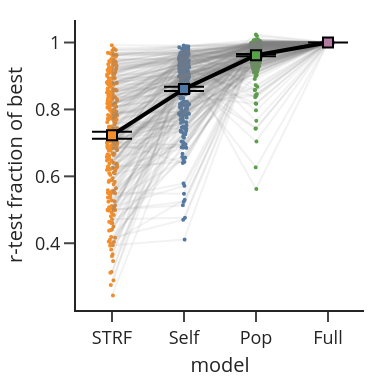

In [14]:
fig = go.Figure()

# single lines grayed out
single_lines = list()
for ll in norm_wide.loc[:, norm_dispnames].values:
    fig.add_trace(
        go.Scatter(x=norm_dispnames, y=ll,
                   mode='lines',
                   opacity=0.1,
                   line=dict(
                       color='gray',
                       width=1),
                   showlegend=False))


# mean and SEM line+markers
mean = norm_wide.loc[:, norm_dispnames].values.mean(axis=0)
err = sem(norm_wide.loc[:, norm_dispnames].values, axis=0)

# added line to this single call, make sure it actually works
fig.add_traces(go.Scatter(x=norm_dispnames, y=mean,
                          mode='markers+lines',
                          opacity=1,
                          showlegend=False,
                          marker=dict(color=[MODEL_COLORMAP[nknm] for nknm in norm_nickname],
                                      symbol='square',
                                      size=5,
                                      line=dict(color='black',
                                                width=1)
                                      ),
                          error_y=dict(array=err,
                                       color='black',
                                       thickness=1,
                                       width=10
                                       ),
                          line=dict(color='black'
                                    )
                          ))

# individual dots
strip = px.strip(toplot_norm, y=stat, x='model', color='model',
                 color_discrete_map={DISPLAY_NAME_MAP[nknm]: clr for nknm, clr in
                                     MODEL_COLORMAP.items()})
strip = strip.update_traces(marker=dict(opacity=1,
                                        size=2)
                            )['data']
fig.add_traces(strip)

# horizontal line for refference model
# fig.add_hline(y=1, line=dict(color=MODEL_COLORMAP[ref_mod],
#                              width=1), opacity=1)


w, h = 2, 2# in inches
_ = fig.update_layout(template='simple_white',
                      margin=dict(l=10, r=10, t=10, b=10),
                      width=round(96 * w), height=round(96 * h),
                      xaxis1=dict(domain=[0, 1], anchor='y1',
                                  title_text='model'),
                      yaxis1=dict(domain=[0, 1], anchor='x1',
                                  # range=[0, 3],
                                  title_text='r-test fraction of best'),
                      showlegend=False,
                      plot_bgcolor='rgba(256,256,256,0.2)')  # background color changes for all subplots,


fig.update_xaxes(title=dict(font_size=10, standoff=0), tickfont_size=9)
fig.update_yaxes(title=dict(font_size=10, standoff=0), tickfont_size=9)

filename = folder / 'fig6_model_rtests_norm'
fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)

 ### get mean and sem values

In [15]:
print(wide.loc[:, display_names].agg(['mean', 'sem', 'std']))

          STRF      Self       Pop      Full
mean  0.279627  0.330370  0.361060  0.373271
sem   0.010166  0.010495  0.010498  0.010548
std   0.168579  0.174041  0.174083  0.174918


### quantifications for model numbers and differences

In [16]:
for m0,m1 in itt.combinations(display_names, r=2):
    out = wilcoxon(wide[m0], wide[m1])
    print(f'Wilcoxon: {m0}vs{m1}, pvalue={out.pvalue}')
model_count = wide.groupby('region', observed=True).agg(count=('id',pd.Series.nunique))
print(model_count)
print(model_count.sum())

Wilcoxon: STRFvsSelf, pvalue=1.1096794006023441e-45
Wilcoxon: STRFvsPop, pvalue=1.4377841065819625e-45
Wilcoxon: STRFvsFull, pvalue=6.0697619934043e-45
Wilcoxon: SelfvsPop, pvalue=7.628527553777529e-32
Wilcoxon: SelfvsFull, pvalue=4.4524255465799155e-44
Wilcoxon: PopvsFull, pvalue=3.888786803050131e-39
        count
region       
A1        200
PEG        75
count    275
dtype: int64


there is an odd discrepancy in the number of neuronse with model fits (237) and those neurons used to do the integral
regresion (227). Presummably the missing 10 neurons were filtered out for the integral calculation based on their
poor contextual effects or reliability.

Indeed I checked this, and all these neurons have 0 real significant contextual modulation
If you read this in the future, trust  your past self Mateo.

In [17]:
# why is there a discrepancy kin cell
r_test_neu = set(wide['id'].unique())
missing = r_test_neu.difference(regr_neu)
missing

{'TNC014a-25-5',
 'TNC015a-07-1',
 'TNC015a-16-5',
 'TNC015a-50-1',
 'TNC015a-55-2',
 'TNC015a-58-2',
 'TNC016a-27-1',
 'TNC016a-28-5',
 'TNC016a-40-3',
 'TNC016a-40-5',
 'TNC016a-43-3',
 'TNC016a-43-7',
 'TNC016a-46-2',
 'TNC016a-55-2',
 'TNC016a-61-2',
 'TNC017a-13-3',
 'TNC017a-14-2',
 'TNC017a-19-4',
 'TNC017a-19-6',
 'TNC017a-24-2',
 'TNC017a-28-2',
 'TNC017a-30-2',
 'TNC017a-30-3',
 'TNC017a-31-4',
 'TNC017a-34-3',
 'TNC017a-38-1',
 'TNC017a-41-3',
 'TNC017a-42-2',
 'TNC017a-45-1',
 'TNC017a-45-2',
 'TNC017a-48-2',
 'TNC017a-49-4',
 'TNC017a-54-3',
 'TNC017a-54-4',
 'TNC017a-54-5',
 'TNC017a-57-2',
 'TNC017a-57-3',
 'TNC017a-58-2',
 'TNC017a-60-2',
 'TNC018a-04-2',
 'TNC018a-05-4',
 'TNC018a-09-2',
 'TNC018a-09-3',
 'TNC018a-10-2',
 'TNC018a-11-1',
 'TNC018a-16-3',
 'TNC018a-20-2',
 'TNC018a-21-3',
 'TNC018a-33-2',
 'TNC018a-35-1',
 'TNC018a-42-6',
 'TNC023a-020-2',
 'TNC023a-031-1',
 'TNC024a-015-1',
 'TNC024a-016-3',
 'TNC024a-027-4'}

# example model fits

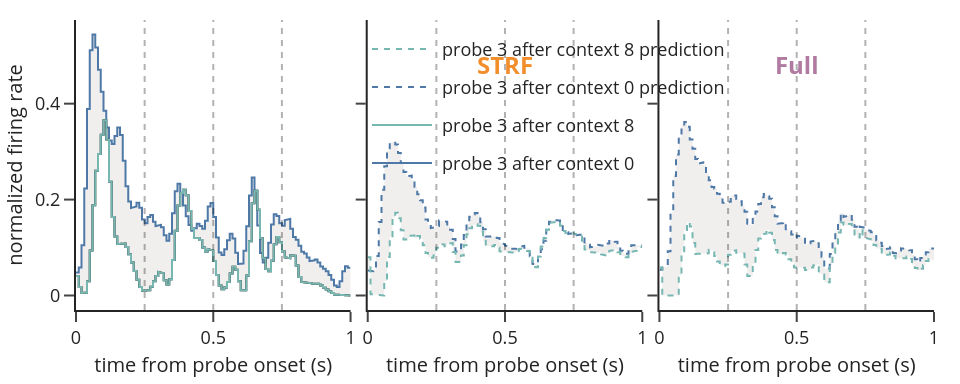

In [20]:
# eg_cellid, eg_contexts, eg_probe = 'TNC014a-22-2', (8, 10), 8 # ?? one of the best neurons for sure
eg_cellid, eg_contexts, eg_probe = 'TNC014a-22-2', (0, 8), 3

combos = [
    ('resp', 'matchl_STRF'),
    ('pred', 'matchl_STRF'),
    # ('pred','matchl_self'),
    # ('pred','matchl_pop'),
    ('pred', 'matchl_full'),
]

fig = make_subplots(1, len(combos), shared_xaxes='all', shared_yaxes='all',
                    horizontal_spacing=0.02)

for cc, (disp, modname) in enumerate(combos):
    if cc == 0:
        sw = 30
    else:
        sw = 0
    f = plot_raw_pair(eg_cellid, eg_contexts, eg_probe,
                      modelname=all_modelnames[modname], batch=batch_map[eg_cellid],
                      part='probe',
                      mod_disp=disp,
                      fill_between=True,
                      raster_fs=100, smoothing_window=sw,
                      colors=TENCOLOR)
    f.update_traces(line_width=1)
    if cc >= 2:
        f.update_traces(showlegend=False)
    t = f['data']
    fig.add_traces(t, cols=[cc + 1] * len(t), rows=[1] * len(t))

    # colored names for the STRFs
    if cc > 0:
        fig.add_trace(go.Scatter(x=[0.5], y=[0.5],
                                 text=[f'<b>{DISPLAY_NAME_MAP[modname]}</b>'],
                                 mode='text', showlegend=False,
                                 textfont=dict(size=12, color=MODEL_COLORMAP[modname]),
                                 textposition='bottom center'
                                 ),
                      col=cc + 1, row=1)

w, h = 5, 2  # in inches
_ = fig.update_layout(
    template='simple_white',
    margin=dict(l=10, r=10, t=10, b=10),
    width=round(96 * w), height=round(96 * h),
    legend=dict(x=1 / 3, y=1, font=dict(size=9),
                bgcolor="rgba(0,0,0,0)")
)

for vline in [0.25, 0.5, 0.75]:
    fig.add_vline(x=vline, line=dict(width=1, dash='dot', color='black'))

fig.update_xaxes(title=dict(text='time from probe onset (s)',
                            font_size=10, standoff=0),
                 tickfont_size=9)
fig.update_yaxes(title=dict(text='normalized firing rate',
                            font_size=10, standoff=0),
                 tickfont_size=9, col=1)

filename = folder / 'fig6_pred_psths'
fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)